In [1]:
import numpy as np
import xarray as xr
from modules.ADI import ADI
from modules.classes import Quantity2D, Analytic
from modules.tests import plot_mass_conservation
import matplotlib.pyplot as plt

In [2]:
# Initialize a constant diffusion coefficient function
diffusion = Analytic(lambda x, y: x*y)
diffusion.set_partial_x(lambda x, y: y)
diffusion.set_partial_y(lambda x, y: x)

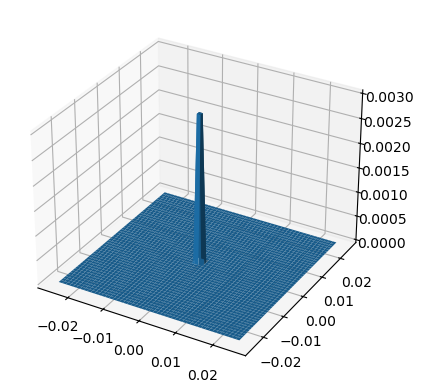

In [3]:
n_grid = 50
n_time = 400
dt = 0.0001
dx = 0.001
dy = 0.001

conc = Quantity2D(
    n_grid,
    n_time,
    (-0.5*n_grid*dx, 0.5*n_grid*dx),
    (-0.5*n_grid*dy, 0.5*n_grid*dy),
    (0, dt*n_time),
)

xcoords = conc.xcoords
ycoords = conc.ycoords
X, Y = np.meshgrid(xcoords, ycoords)
initial_condition =  100*np.exp(- (X**2 + Y**2)/(0.000001*dx*n_grid))
#initial_condition = np.empty_like(X)
#initial_condition[n_grid//2, n_grid//2] = 100

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, initial_condition)

In [4]:
result_ds = ADI(conc, diffusion, initial_condition)
# Issue with explicit component vectors blowing up to infinity/nan values

In [5]:
result_ds

<xarray.DataArray 'concentration' (x: 50, y: 50, t: 400)> Size: 8MB
array([[[ 0.00000000e+00,  2.81993946e-98,  3.64737132e-17, ...,
          3.67517917e+58,  5.64586939e+58,  8.67327513e+58],
        [ 0.00000000e+00, -1.83324928e-96, -2.37116543e-15, ...,
         -6.69884031e+57, -1.02807177e+58, -1.57778194e+58],
        [ 0.00000000e+00, -1.86104421e-96, -2.40711600e-15, ...,
         -4.64230777e+58, -7.12967539e+58, -1.09497849e+59],
        ...,
        [ 0.00000000e+00, -1.86188785e-96, -2.40820719e-15, ...,
         -1.54732542e+58, -2.37547420e+58, -3.64685829e+58],
        [ 0.00000000e+00, -1.83247649e-96, -2.37016589e-15, ...,
         -1.51478402e+58, -2.32551655e+58, -3.57016318e+58],
        [ 0.00000000e+00, -3.69392516e-96, -4.77780505e-15, ...,
         -1.53239687e+58, -2.35254865e+58, -3.61165188e+58]],

       [[ 0.00000000e+00,  2.54058150e-98,  3.29454894e-17, ...,
          8.07363938e+58,  1.24011503e+59,  1.90482286e+59],
        [ 0.00000000e+00, -1.72207661e-96, -2.23308233e-15, ...,
          5.34693156e+57,  8.21391670e+57,  1.26181577e+58],
        [ 0.00000000e+00, -1.74713252e-96, -2.26557384e-15, ...,
         -6.34867930e+58, -9.75144467e+58, -1.49780244e+59],
...
        [ 0.00000000e+00, -1.74783233e-96, -2.27739502e-15, ...,
          2.45869312e+56,  3.77675566e+56,  5.80140853e+56],
        [ 0.00000000e+00, -1.77288824e-96, -2.31004301e-15, ...,
          2.41616716e+56,  3.71151363e+56,  5.70131635e+56],
        [ 0.00000000e+00, -3.52037067e-96, -4.58698308e-15, ...,
          3.30321447e+56,  5.07408907e+56,  7.79434094e+56]],

       [[ 0.00000000e+00, -2.89721813e-98, -3.76525457e-17, ...,
          1.45589453e+59,  2.23624965e+59,  3.43487280e+59],
        [ 0.00000000e+00, -1.89042085e-96, -2.45691679e-15, ...,
          1.10885374e+58,  1.70319958e+58,  2.61611492e+58],
        [ 0.00000000e+00, -1.86100950e-96, -2.41869311e-15, ...,
         -1.37100577e+59, -2.10585998e+59, -3.23459346e+59],
        ...,
        [ 0.00000000e+00, -1.86185314e-96, -2.41978801e-15, ...,
          2.80974008e+56,  4.31603869e+56,  6.62986226e+56],
        [ 0.00000000e+00, -1.88964807e-96, -2.45591329e-15, ...,
          2.74885578e+56,  4.22262350e+56,  6.48653490e+56],
        [ 0.00000000e+00, -3.75109674e-96, -4.87517756e-15, ...,
          3.67485488e+56,  5.64505178e+56,  8.67152863e+56]]])
Coordinates:
  * x        (x) float64 400B -0.025 -0.02398 -0.02296 ... 0.02296 0.02398 0.025
  * y        (y) float64 400B -0.025 -0.02398 -0.02296 ... 0.02296 0.02398 0.025
  * t        (t) float64 3kB 0.0 0.0001003 0.0002005 ... 0.0398 0.0399 0.04
Attributes:
    dx:                     0.0010204081632653062
    dy:                     0.0010204081632653062
    dt:                     0.00010025062656641604
    n_grid:                 50
    n_time:                 400
    initial_condition:      [[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0....
    diffusion_coefficient:  [[ 0.000625    0.00059949  0.00057398 ... -0.0005...
    metadata:               Generated by crank_nicholson_1D

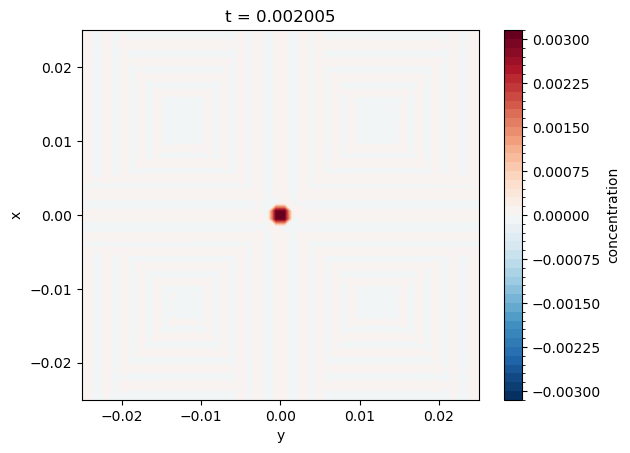

In [10]:
xr.plot.contourf(result_ds.isel(t=20), levels=50)

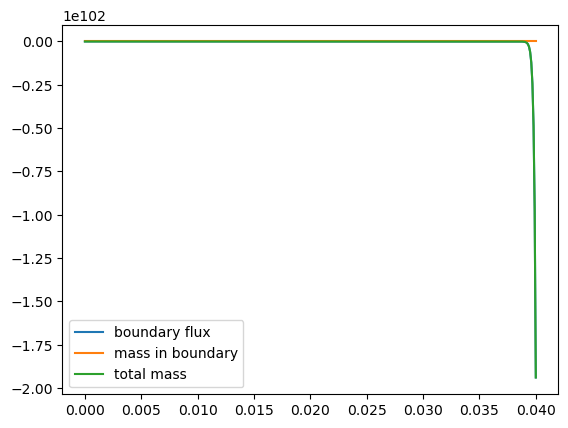

In [7]:
fig, ax = plot_mass_conservation(result_ds)

In [8]:
D = np.array(
    [[1,1],
    [2,2]]
)
print(D[:,0])

[1 2]


In [9]:
a = np.ones(5)
b = np.linspace(1,5,5)
print(a@b)

15.0
